In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle
%matplotlib inline

In [2]:
url = "https://opendata.arcgis.com/datasets/5a56c7a8daf04cb0bf584ffca72d8e46_100.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
df = pd.read_csv(url)

In [3]:
df.shape

(1316, 29)

In [4]:
df.head()

,X,Y,OBJECTID,PMT_ID,VERIFIEDBY,VERIFYDATE,INSERTED_BY,INSERTED_DATE,CHANGED_BY,CHANGED_DATE,REFERENCE_POINT,PMT_ID_1,PMT_ALPHA_ID,PMT_NUMERIC_ID,PMT_STATUS,POS_DESC,DES_FIRST_NAME,DES_LAST_NAME,SIT_NAME,WSF_REC_CODE,FAC_NAME,FAC_LOCATION,FAC_L_ADDR_1,FAC_L_CITY,FAC_L_STATE,FAC_L_ZIP5,FAC_FIC_COUNTY,LA_LSWPU_ID,LSWPU_NAME
0,-8.597977e+06,4.676932e+06,1,900000000716,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,900000000716,SWP,331,P,Post Closure,Yurek,Aurelson,Lorton CDD Landfill,NVRO,Lorton Construction Landfill,10001 Furnace Rd - Route 611,10001 Furnace Rd,Lorton,VA,22079.0,59,14,Fairfax County
1,-8.624165e+06,4.710218e+06,2,900000000263,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,900000000263,PBR,141,P,Active,Yurek,Aurelson,Loudoun Composting,NVRO,Loudoun Composting,Rte 50 W to Pleasant Valley Rd to Wade Dr,44150 Wade Dr,Chantilly,VA,20152.0,107,1,Loudoun County
2,-8.686951e+06,4.611109e+06,3,900000000718,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,900000000718,PBR,290,R,Closed,Waste Staff,Unknown,Loudoun Hospital Center,NVRO,Loudoun Hospital Center,NaN,NaN,NaN,NaN,NaN,137,49,Orange County
3,-8.669978e+06,4.577910e+06,4,900000000267,ZMRABEI,2016/05/13 15:16:20+00,NaN,1970/01/01 00:00:00+00,ZMRABEI,2016/05/13 15:16:20+00,FC,900000000267,SWP,567,P,Active,Kathryn,Perszyk,Louisa County Landfill,NVRO,Louisa County Sanitary Landfill,807 Moorefield Rd,807 Moorefield Rd,Mineral,VA,23117.0,109,2,Louisa County
4,-8.670119e+06,4.577621e+06,5,900000000266,YGAURELSON,2016/03/15 13:24:14+00,NaN,1970/01/01 00:00:00+00,YGAURELSON,2016/03/15 13:24:14+00,FC,900000000266,SWP,194,P,Post Closure,Yurek,Aurelson,Louisa County Landfill,NVRO,Louisa County Sanitary Landfill,807 Moorefield Rd,807 Moorefield Rd,Mineral,VA,23117.0,109,2,Louisa County


In [7]:
df_cleaned = df.dropna(subset=['FAC_L_ADDR_1', 'FAC_L_CITY', 'FAC_L_STATE', 'FAC_L_ZIP5'])
df_cleaned["Full_Address"] = df_cleaned.apply(lambda row: row.FAC_L_ADDR_1 + "," + row.FAC_L_CITY + ",VA,United States", axis=1)
df_cleaned["Minimal_Address"] = df_cleaned.apply(lambda row: row.FAC_L_CITY + ",VA,United States", axis=1)
df_cleaned = df_cleaned.drop_duplicates(subset=['Full_Address'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
df_cleaned.head()

,X,Y,OBJECTID,PMT_ID,VERIFIEDBY,VERIFYDATE,INSERTED_BY,INSERTED_DATE,CHANGED_BY,CHANGED_DATE,REFERENCE_POINT,PMT_ID_1,PMT_ALPHA_ID,PMT_NUMERIC_ID,PMT_STATUS,POS_DESC,DES_FIRST_NAME,DES_LAST_NAME,SIT_NAME,WSF_REC_CODE,FAC_NAME,FAC_LOCATION,FAC_L_ADDR_1,FAC_L_CITY,FAC_L_STATE,FAC_L_ZIP5,FAC_FIC_COUNTY,LA_LSWPU_ID,LSWPU_NAME,Full_Address,Minimal_Address
0,-8.597977e+06,4.676932e+06,1,900000000716,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,900000000716,SWP,331,P,Post Closure,Yurek,Aurelson,Lorton CDD Landfill,NVRO,Lorton Construction Landfill,10001 Furnace Rd - Route 611,10001 Furnace Rd,Lorton,VA,22079.0,59,14,Fairfax County,"10001 Furnace Rd,Lorton,VA,United States","Lorton,VA,United States"
1,-8.624165e+06,4.710218e+06,2,900000000263,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,900000000263,PBR,141,P,Active,Yurek,Aurelson,Loudoun Composting,NVRO,Loudoun Composting,Rte 50 W to Pleasant Valley Rd to Wade Dr,44150 Wade Dr,Chantilly,VA,20152.0,107,1,Loudoun County,"44150 Wade Dr,Chantilly,VA,United States","Chantilly,VA,United States"
3,-8.669978e+06,4.577910e+06,4,900000000267,ZMRABEI,2016/05/13 15:16:20+00,NaN,1970/01/01 00:00:00+00,ZMRABEI,2016/05/13 15:16:20+00,FC,900000000267,SWP,567,P,Active,Kathryn,Perszyk,Louisa County Landfill,NVRO,Louisa County Sanitary Landfill,807 Moorefield Rd,807 Moorefield Rd,Mineral,VA,23117.0,109,2,Louisa County,"807 Moorefield Rd,Mineral,VA,United States","Mineral,VA,United States"
7,-8.904459e+06,4.478607e+06,8,900000000710,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,900000000710,PBR,136,P,Active,Jenny,Poland,LCM Transfer Station,WCRO,LCM Corp - Transfer Station,NaN,3321 Shenandoah Ave NW,Roanoke,VA,24034.0,770,16,City of Roanoke,"3321 Shenandoah Ave NW,Roanoke,VA,United States","Roanoke,VA,United States"
10,-9.249748e+06,4.395041e+06,11,900000000712,SJMARTIN,2017/04/05 14:41:57+00,NaN,1970/01/01 00:00:00+00,SJMARTIN,2017/04/05 14:41:56+00,FC,900000000712,PBR,070,P,Active,Daniel,Scott,Lee County Solid Waste Transfer Station,SWRO,Lee County Solid Waste Transfer Station,.5 miles off St Rte 58 near Jonesville,.5 MI off St Rte 58,Jonesville,VA,24263.0,105,27,Lee County,".5 MI off St Rte 58,Jonesville,VA,United States","Jonesville,VA,United States"


In [9]:
df_cleaned.shape

(665, 31)

In [10]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="my_user_agent")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.1)

In [11]:
def lat_long_converter(geocode, full_address, minimum_address):
  loc = geocode(full_address)
  if not loc:
    loc = geocode(minimum_address)
  if not loc:
    return None
  loc = tuple(loc.point)
  lat_bound = loc[0] < 36 or loc[0] > 39.5
  long_bound = loc[1] < -84 or loc[1] > -75
  if lat_bound or long_bound:
    return None
  else:
    return loc 

In [ ]:
# 1 - conveneint function to delay between geocoding calls
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# 2- - create location column
# df_cleaned['location'] = df_cleaned['Minimal_Address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
# df_cleaned['point'] = df_cleaned['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
# df_cleaned[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_cleaned['point'].tolist(), index=df_cleaned.index)

In [12]:
import time
start_time = time.time()
df_cleaned["coordinate"] = df_cleaned.apply(lambda row: lat_long_converter(geocode, row.Full_Address, row.Minimal_Address), axis=1)
end_time = time.time()
df_cleaned[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_cleaned['coordinate'].tolist(), index=df_cleaned.index)

In [13]:
elapsed_time = end_time-start_time
print("Total time: {}".format(elapsed_time))
print("Time per entry: {}".format(elapsed_time/665))

Total time: 480.4072337150574
Time per entry: 0.7224168928045975


In [14]:
df_cleaned = df_cleaned.dropna(subset=['coordinate'])

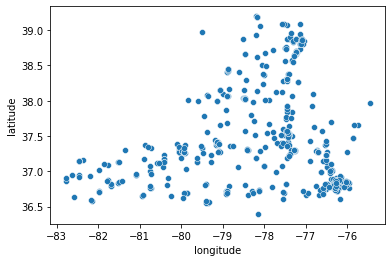

In [15]:
sns.scatterplot(x="longitude", y="latitude", data=df_cleaned)

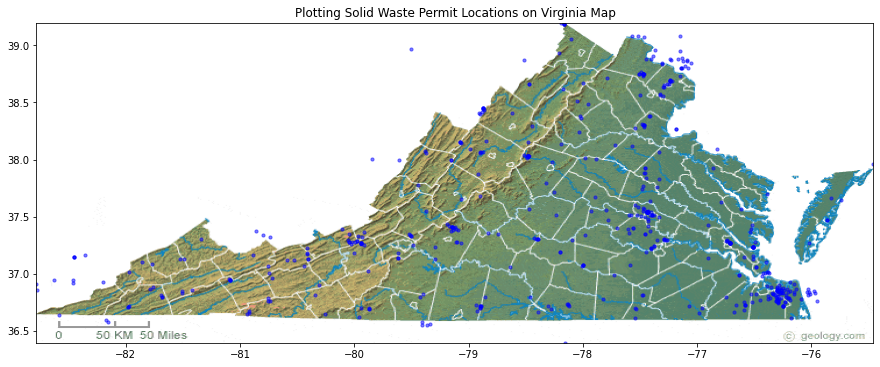

In [17]:
ruh_m = plt.imread('virginia-physical-map.gif')
BBox = ((df_cleaned.longitude.min(),   df_cleaned.longitude.max(),      
         df_cleaned.latitude.min(), df_cleaned.latitude.max()))

fig, ax = plt.subplots(figsize = (15, 15))
ax.scatter(df_cleaned.longitude, df_cleaned.latitude, zorder=1, alpha= 0.5, c='b', s=10)
ax.set_title('Plotting Solid Waste Permit Locations on Virginia Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [19]:
df_final = df_cleaned[["FAC_NAME", "FAC_LOCATION", "LSWPU_NAME", "Full_Address", "Minimal_Address", "latitude", "longitude"]]
df_final.to_pickle("solid_waste.pkl")

In [21]:
loc = geolocator.geocode("Charles City,VA,United States")
print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

latitude is :- 43.0663613 
longtitude is:- -92.6724112


In [ ]:
location = geolocator.reverse("36.724867 , -78.12978575")
print(location.address)

Bit Communications, East Pine Lane, South Hill, Mecklenburg County, Virginia, 23970, United States


In [ ]:
test_string = "2518 Centre Ave NW,Roanoke,VA,United States"
",".join(test_string.split(",")[1:])

'Roanoke,VA,United States'